## Exemplary scripts generating synthetic data

In [1]:
# Standard code libraries

import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt

from resurfemg import helper_functions as hf
from resurfemg.helper_functions.config import Config 
config = Config()

# Then find the files for the selected patients:
base_path = config.get_directory('preprocessed')

%matplotlib widget

In [2]:
base_path

'C:/Users/robwa/repos/work/ReSurfEMG/test_data/preprocessed'

In [3]:
# Custom code libraries from the ReSurfEMG repository
# from resurfemg.data_connector.synthetic_data import simulate_emg_with_occlusions
from resurfemg.pipelines.synthetic_data import simulate_raw_emg, synthetic_emg_cli
from resurfemg.data_connector.synthetic_data import simulate_ventilator_with_occlusions

import resurfemg.preprocessing.ecg_removal as ecg_rm
import resurfemg.preprocessing.envelope as evl
import resurfemg.preprocessing.filtering as filt
import resurfemg.postprocessing.features as feat

## 2. Simulate the ventilator and sEMG data

2.a Generate a patient and set the recording setting

In [4]:
# Experimemt settings
patient = 'HSP001'
measurement_date = 'XXXX_XX_XX_measurement_01'
recording_numbers = ['001', '002', '003', '004']
peep_steps = [3, 5, 7, 9]   # The PEEP steps to iterate (cmH2O)

# Recording parameters
t_rec = 7*60                # Recording duration (s)
fs_vent = 100               # Sampling rate of ventilator (Hz)
fs_emg = 2048               # Sampling rate of EMG amplifier (Hz)

# Ventilator parameters
dp = 8                      # Driving pressure above PEEP (cmH2O)  

# Patient respiratory variables
ie_ratio = 1/2              # Ratio between inspiratory and expiratory time
rr = 22                     # Respiratory rate (/min)
p_mus_max_0_PEEP = 10       # Maximal respiratory muscle pressure (cmH2O)
c = .050                    # Respiratory system compliance (L/cmH2O)
r = 5                       # Respiratory system resistance (cmH2O/L/s)
p_ip = -5                   # Static interpleural pressure (cmH2O)

tau_mus_up = 0.3            # Muscle contraction time constant
tau_mus_down = 0.3          # Muscle release time constant

# Cardiac parameters
hr_min = 60                 # Minimal heart rate (bpm)
hr_max = 100                # Maximal heart rate (bpm)

# Occlussion manoeuvre (Pocc) settings
t_occs = np.array([t_rec-45, t_rec-30, t_rec-15])
t_occs = np.floor(t_occs*rr/60)*60/rr   # Sync Poccs with respiratory pattern
for i, t_occ in enumerate(t_occs):
    if t_rec < (t_occ + 60/rr):
        print('t=' + str(t_occ) + ': t_occ should be at least a full '
              + 'respiratory cycle from t_end')
        
# Initialise expirement outputs
big_data_list = []
columns_now = ['patient', 'measurement', 'PEEP_set', 
                   'PTP_occs', 'ETP_di_occs', 'NMC_di', 
                   'SNR_di', 'PTP_occ_baseline', 'ETP_di_baseline', 
                   'ETP_di_baseline_old', 'ETP_di_bell_SE',
                   't_delta_di_med', 't_delta_ecg_med', 
                   't_Pocc_peak', 't_Pocc_start', 't_Pocc_end',
                   't_di_peak', 't_di_start', 't_di_end',
                   'dP_up_10', 'dP_up_90', 'dP_up_90_norm', 'double_dip'
               ]

df = pd.DataFrame(big_data_list, columns=columns_now)

2.b Select and set the next PEEP step

In [5]:
# Get the PEEP step index and the corresponding recording number and PEEP value
PEEP_idx = len(set(df['measurement'].values)) 
PEEP_step_chosen = recording_numbers[PEEP_idx]
peep = peep_steps[PEEP_idx]        # Positive end-expiratory pressure (cmH2O)

# Create a virtual trial effect:
#   Change the maximal tidal inspiratory pressure of the patient
p_mus_max = (1 - 0.049 * peep) * p_mus_max_0_PEEP 

print('The next PEEP step is:' 
      + '\nPatient: ' + patient
      + '\nMeasurement date: ' + measurement_date
      + '\nRecording: ' + PEEP_step_chosen 
      + '\nPEEP: ' + str(peep) + ' cmH2O')

The next PEEP step is:
Patient: HSP001
Measurement date: XXXX_XX_XX_measurement_01
Recording: 001
PEEP: 3 cmH2O


2.c Generate the ventilator and sEMG data for the next PEEP step

In [6]:
# Generate ECG data
hr = random.randint(hr_min, hr_max)
# part_ecg = nk.ecg_simulate(duration=int(t_rec/1.5), 
#                            sampling_rate=int(fs_emg*1.5), 
#                            heart_rate=hr) 

print('The randomised heart rate is set at: ', hr, 'bpm')

The randomised heart rate is set at:  74 bpm


In [7]:
sim_amp = lambda emg_amp: simulate_raw_emg(
    t_p_occs=t_occs,
    t_end=t_rec,
    fs_emg=fs_emg,
    rr=rr,         
    ie_ratio=ie_ratio,
    tau_mus_up=0.3,
    tau_mus_down=0.3,
    emg_amp=emg_amp,     # Approximate EMG-RMS amplitude (uV)
    drift_amp=100, # Approximate drift RMS amplitude (uV)
    noise_amp=2,    # Approximate baseline noise RMS amplitude (uV)
    heart_rate=hr,
    ecg_acceleration=1.6,
)
y_emg_remix = np.zeros((2, int(fs_emg*t_rec)))
y_emg_remix[0] = sim_amp(0.2)
y_emg_remix[1] = sim_amp(5)

In [8]:
y_vent = simulate_ventilator_with_occlusions(
    t_p_occs=t_occs,     # Timing of occlusions (s)
    t_start=0,
    t_end=t_rec,
    fs_vent=fs_vent,            # hertz
    rr=rr,                      # respiratory rate /min
    ie_ratio=ie_ratio,          # Ratio between inspiratory and expiratory time
    p_mus_max=p_mus_max,        # Maximal respiratory muscle pressure (cmH2O)
    tau_mus_up=tau_mus_up,      # Muscle contraction time constant
    tau_mus_down=tau_mus_down,  # Muscle release time constant
    c=c,                        # Respiratory system compliance (L/cmH2O)
    r=r,                        # Respiratory system resistance (cmH2O/L/s)
    peep=peep,                  # Positive end-expiratory pressure (cmH2O)
    dp=dp                       # Driving pressure above PEEP (cmH2O)
)

In [9]:
# Load the EMG and ventilator data recordings from the selected folders.
# data_emg = Poly5Reader(emg_file_chosen)
# data_vent = Poly5Reader(vent_file_chosen)
data_emg_samples = y_emg_remix
emg_fs = fs_emg
data_vent_samples = y_vent
vent_fs = fs_vent

# Define the time series of the EMG and ventilator recordings
y_emg = y_emg_remix
y_vent = y_vent

# Define the time axes
t_emg = [i/emg_fs for i in range(len(y_emg[0, :]))]
t_vent = [i/vent_fs for i in range(len(y_vent[0, :]))]

# Default settings for window of interest including the end-expiratory occlusion
# manoeuvres (Pocc)
t_start_default = t_vent[-1]-60
t_end_default = t_vent[-1]-5

Text(0.5, 0, 't (s)')

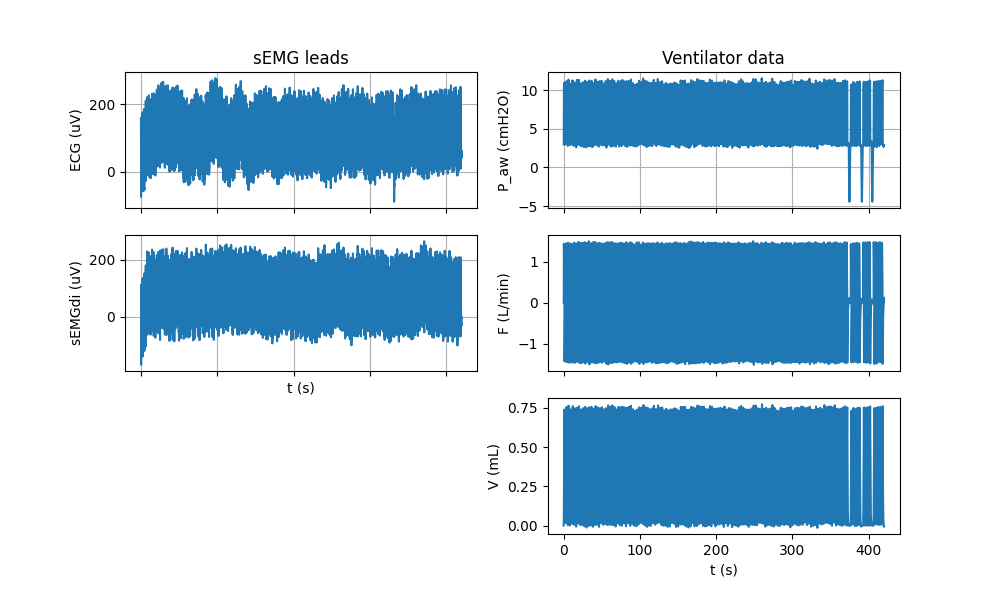

In [10]:
# Plot the raw data
fig, axis = plt.subplots(nrows=3, ncols=2, figsize=(10, 6), sharex=True)

axis[0, 0].grid(True)
axis[0, 0].plot(t_emg, y_emg[0])
axis[0, 0].set(title='sEMG leads')
axis[0, 0].set_ylabel('ECG (uV)')
axis[1, 0].grid(True)
axis[1, 0].plot(t_emg, y_emg[1])
axis[1, 0].set_ylabel('sEMGdi (uV)')
axis[1, 0].set_xlabel('t (s)')
axis[2, 0].axis('off')

axis[0, 1].set(title='Ventilator data')
axis[0, 1].grid(True)
axis[0, 1].plot(t_vent, y_vent[0])
axis[0, 1].set_ylabel('P_aw (cmH2O)')
axis[1, 1].plot(t_vent, y_vent[1])
axis[1, 1].set_ylabel('F (L/min)')
axis[2, 1].plot(t_vent, y_vent[2])
axis[2, 1].set_ylabel('V (mL)')
axis[2, 1].set_xlabel('t (s)')

In [11]:
sim_parameters = {
        't_end': 7*60,
        'fs_emg': 2048,   # hertz
        'rr': 22,         # respiratory rate /min
        'ie_ratio': 1/2,  # ratio btw insp + expir phase
        'tau_mus_up': 0.3,
        'tau_mus_down': 0.3,
        't_p_occs': [],
        'drift_amp': 100,
        'noise_amp': 2,
        'heart_rate':80,
        'ecg_acceleration': 1.5,
        'ecg_amplitude':200,
    }

In [12]:
simulate_raw_emg(**sim_parameters)

array([178.06169132, 178.16346355, 178.56684276, ..., 128.2469466 ,
       123.69372878, 129.2360277 ])

In [13]:
output_directory = base_path
synthetic_emg_cli(1, output_directory)